In [161]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt

from utils import explain

#### Create Dataframes

In [84]:
files = sorted(['data/' + _ for _ in os.listdir('data/') if '.txt' not in _])

['data/bus_char_df.csv', 'data/bus_own_df.csv', 'data/bus_tech_df.csv', 'data/comp_sum_df.csv', 'data/slbo.csv', 'data/state_codes.csv']


In [85]:
bus_char_df = pd.read_csv(files[0])
bus_own_df = pd.read_csv(files[1])
bus_tech_df = pd.read_csv(files[2])
comp_sum_df = pd.read_csv(files[3])
slbo = pd.read_csv(files[4])

state_codes = pd.read_csv(files[5])


In [86]:
bus_char_df[(bus_char_df.rcppdemp != '0')]

,name,buschar_label,emp,firmpdemp,geo_id,industry_code,industry,payann,qdesc_label,race_group_label,rcppdemp,gender,yibszfi_label,state
0,Mississippi,All firms,920447,40856,0400000US28,0,Total for all sectors,34137231,OWNRNUM,Total,0,Total,All firms,28]
1,Mississippi,1 person,80964,10704,0400000US28,0,Total for all sectors,2835519,OWNRNUM,Total,0,Total,All firms,28]
2,Mississippi,2 to 4 people,59086,5956,0400000US28,0,Total for all sectors,2031186,OWNRNUM,Total,0,Total,All firms,28]
3,Mississippi,5 to 10 people,13497,360,0400000US28,0,Total for all sectors,618245,OWNRNUM,Total,0,Total,All firms,28]
4,Mississippi,11 or more people,106361,604,0400000US28,0,Total for all sectors,4807141,OWNRNUM,Total,0,Total,All firms,28]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2290,Minnesota,All firms,2673014,113774,0400000US27,0,Total for all sectors,146712564,CEASEOPS,Total,0,Total,All firms,27]
2291,Minnesota,Business is currently operating,1296808,60890,0400000US27,0,Total for all sectors,79058091,CEASEOPS,Total,0,Total,All firms,27]
2292,Minnesota,Business operations have ceased,46296,2817,0400000US27,0,Total for all sectors,1372367,CEASEOPS,Total,0,Total,All firms,27]
2293,Minnesota,Total reporting,1343105,63706,0400000US27,0,Total for all sectors,80430458,CEASEOPS,Total,0,Total,All firms,27]


In [151]:
comp_sum_subset = comp_sum_df[(comp_sum_df.payann != 0) & (comp_sum_df.gender != 'Total') & (comp_sum_df.race_group_label != 'Total') & (comp_sum_df.industry_code != '00')]
comp_sum_subset = comp_sum_subset[['name','geo_id','industry','payann','firmpdemp','emp']]
comp_sum_subset['payann'] = comp_sum_subset['payann'] * 1000
comp_sum_subset['avg_pay'] = comp_sum_subset.apply(lambda row: row.payann/row.emp, axis = 1)
comp_sum_subset

,name,geo_id,industry,payann,firmpdemp,emp,avg_pay
28,Mississippi,0400000US28,Manufacturing,139662000,190,3690,37848.780488
29,Mississippi,0400000US28,Manufacturing,1609367000,1087,39420,40826.154236
70,Mississippi,0400000US28,"Mining, quarrying, and oil and gas extraction",44703000,189,995,44927.638191
197,Mississippi,0400000US28,Construction,1842077000,3375,38369,48009.512888
311,Mississippi,0400000US28,Utilities,87096000,65,1321,65931.869796
...,...,...,...,...,...,...,...
86155,Minnesota,0400000US27,Health care and social assistance,991327000,2511,36007,27531.507762
86156,Minnesota,0400000US27,Health care and social assistance,2637768000,3857,72661,36302.390553
86157,Minnesota,0400000US27,Health care and social assistance,425306000,944,13300,31977.894737
86182,Minnesota,0400000US27,Other services (except public administration),405091000,2061,16473,24591.209859


In [152]:
comp_sum_subset_agg = comp_sum_subset.groupby(
    by = ['name']
        )[['avg_pay']].agg(max_pay = ('avg_pay','max'))

comp_sum_subset_agg.reset_index(inplace = True)

In [153]:
grouped = pd.merge(comp_sum_subset, comp_sum_subset_agg, left_on = 'name', right_on = 'name', how = 'left')
grouped = grouped[(grouped.avg_pay == grouped.max_pay)].reset_index(drop = True)
grouped = grouped.sort_values(by = 'name').reset_index(drop = True)
grouped = grouped.drop_duplicates().reset_index(drop = True)

In [154]:
grouped = pd.merge(grouped,state_codes, left_on = 'name', right_on = 'State', how = 'left')

In [155]:
grouped = grouped[['name','industry','avg_pay','Postal Abbr.']]

In [156]:
set(comp_sum_subset_agg.name.tolist()) - set(grouped.name.tolist())

set()

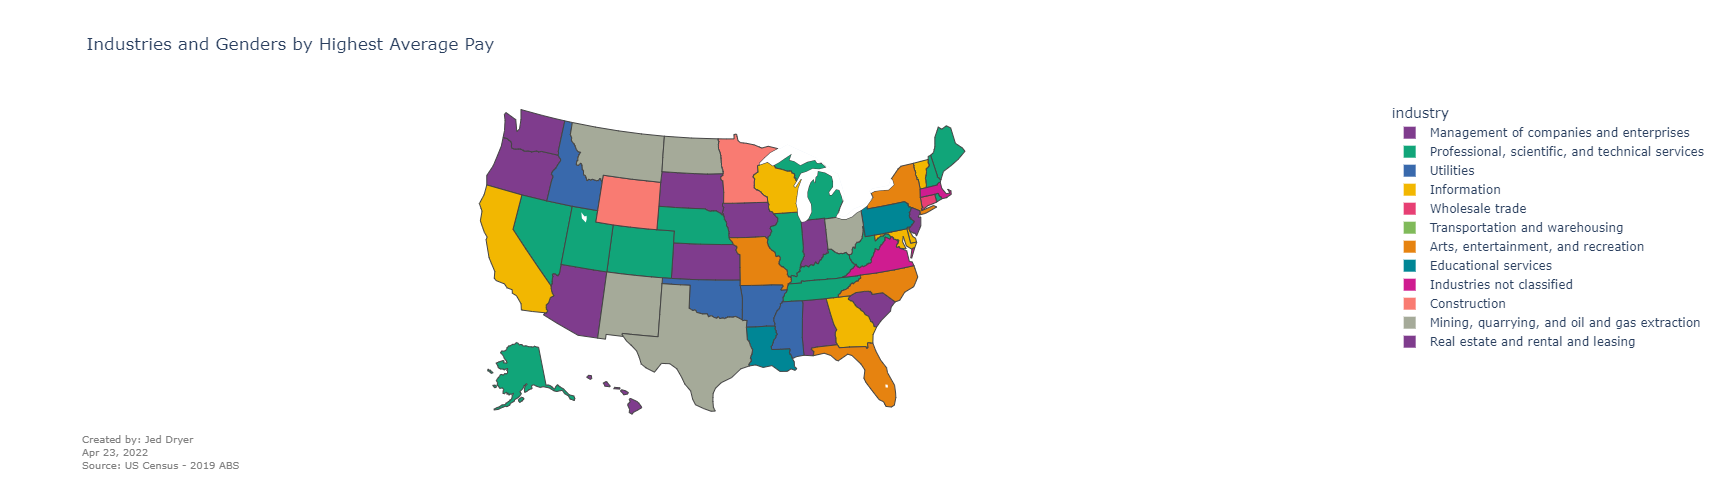

In [174]:
today = dt.datetime.strftime(dt.datetime.today().date(), '%b %d, %Y')

mapfig = px.choropleth(grouped, 
                       title = 'Industries and Genders by Highest Average Pay',
                       locations = 'Postal Abbr.',
                       locationmode = "USA-states",
                       scope = 'usa',
                       color = 'industry',
                       hover_data = ['name','industry','avg_pay'],
                       color_discrete_sequence = px.colors.qualitative.Bold,
                      height = 500,
                      width = 1000)

mapfig.add_annotation(
    text = (f"Created by: Jed Dryer<br>{today}<br>Source: US Census - 2019 ABS")
    , showarrow=False
    , x = 0
    , y = -0.15
    , xref='paper'
    , yref='paper' 
    , xanchor='left'
    , yanchor='bottom'
    , xshift=-1
    , yshift=-5
    , font=dict(size=10, color="grey")
    , align="left"
    ,)

mapfig.show()

In [138]:
for item in mapfig.data:
    print(item,"\n")

Choropleth({
    'colorscale': [[0.0, 'rgb(127, 60, 141)'], [1.0, 'rgb(127, 60, 141)']],
    'customdata': array([['Alabama', 'Management of companies and enterprises', 'Male',
                          98009.1407678245],
                         ['Arizona', 'Management of companies and enterprises', 'Male',
                          117559.8918736273],
                         ['Hawaii', 'Management of companies and enterprises', 'Male',
                          109974.42922374429],
                         ['Indiana', 'Management of companies and enterprises', 'Male',
                          100264.32653061225],
                         ['Iowa', 'Management of companies and enterprises', 'Female',
                          118480.97412480974],
                         ['Kansas', 'Management of companies and enterprises', 'Male',
                          88450.69337442219],
                         ['Oregon', 'Management of companies and enterprises',
                          'Eq

In [122]:
hover_scatter = [scatt for scatt in mapfig.data if scatt.mode == 'locations'][0]
print(hover_scatter)

AttributeError: 'Choropleth' object has no attribute 'mode'

In [14]:
def jeds_first_plot(comp_sum_df):
    import matplotlib.pyplot as plt
    import seaborn as sns

    targ1 = 23
    targ2 = 52
    targ1,targ2 = str(targ1), str(targ2)

    gender_by_state_cs = comp_sum_df[
        (comp_sum_df['industry_code'].isin([targ1, targ2]))
        ].groupby(by = ['name','industry','gender']
                 )[['gender']].agg('count').rename(columns = {'gender': 'gender_count'}).reset_index()

    gender_by_state_cs.sort_values(by = ['name', 'industry', 'gender'], inplace = True)
    gs = gender_by_state_cs

    print('NOTE: Ratios are for each set of observations and not industry specific.')
    print('Building Plots... Please Wait...')
    fig, axs = plt.subplots(51,1, figsize=(15,200), sharex = False)
    fig.suptitle('Ownership Gender in a Subset of Industries by State', fontsize = 30)
    colors = {'Female':'#FD6320','Male':'#9567FE', 'Equally male/female': '#919584'}

    states = sorted(comp_sum_df.name.unique().tolist())
    for i, state in enumerate(states):
        axs[i].set_title(state, fontsize = 20)

        subset = gs[
                (gs['name'] == state) &
                (gs['gender'] != 'Total')
            ] 
        industries = sorted(subset.industry.unique().tolist())
        sns.barplot(data = subset, x = 'industry', y = 'gender_count', 
                    ax = axs[i], hue = 'gender', 
                    palette = colors, 
                    edgecolor = 'black')

        axs[i].set_ylabel('')
        axs[i].set_xlabel('')

        font = {'color': 'w',
                'weight': 'bold',
                'size': 14,
               }
        if i % 3 == 0:
            axs[i].text(-0.36,0.65, "Equal Gender\nOwnership", fontdict = font)
            axs[i].text(-0.05,0.65, "Female", fontdict = font)
            axs[i].text(0.23,0.65, "Male", fontdict = font)

        axs[i].get_legend().remove()
        axs[i].tick_params(left = False)
        axs[i].set_yticklabels('')

        gender_count = subset['gender_count'].sum()
        for c in axs[i].containers:
            labels = [
                f'{(h/gender_count)*100:0.1f}%' if (
                    h := v.get_height()) > 0 else "" for v in c
            ]

            axs[i].bar_label(c,labels=labels,label_type = 'edge',fontsize = 17,color= 'black')
        axs[i].tick_params(axis = 'x', labelsize = 18)

    plt.tight_layout()
    plt.subplots_adjust(hspace = 1,top = 0.97)
    sns.despine(left = True, bottom = True)
    print('Done... Displaying Plots...')

    #plt.savefig('gender_ownership_state.pdf')
#jeds_first_plot(comp_sum_df)  ## Uncomment to run the plot

C:\Users\Work\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Work\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



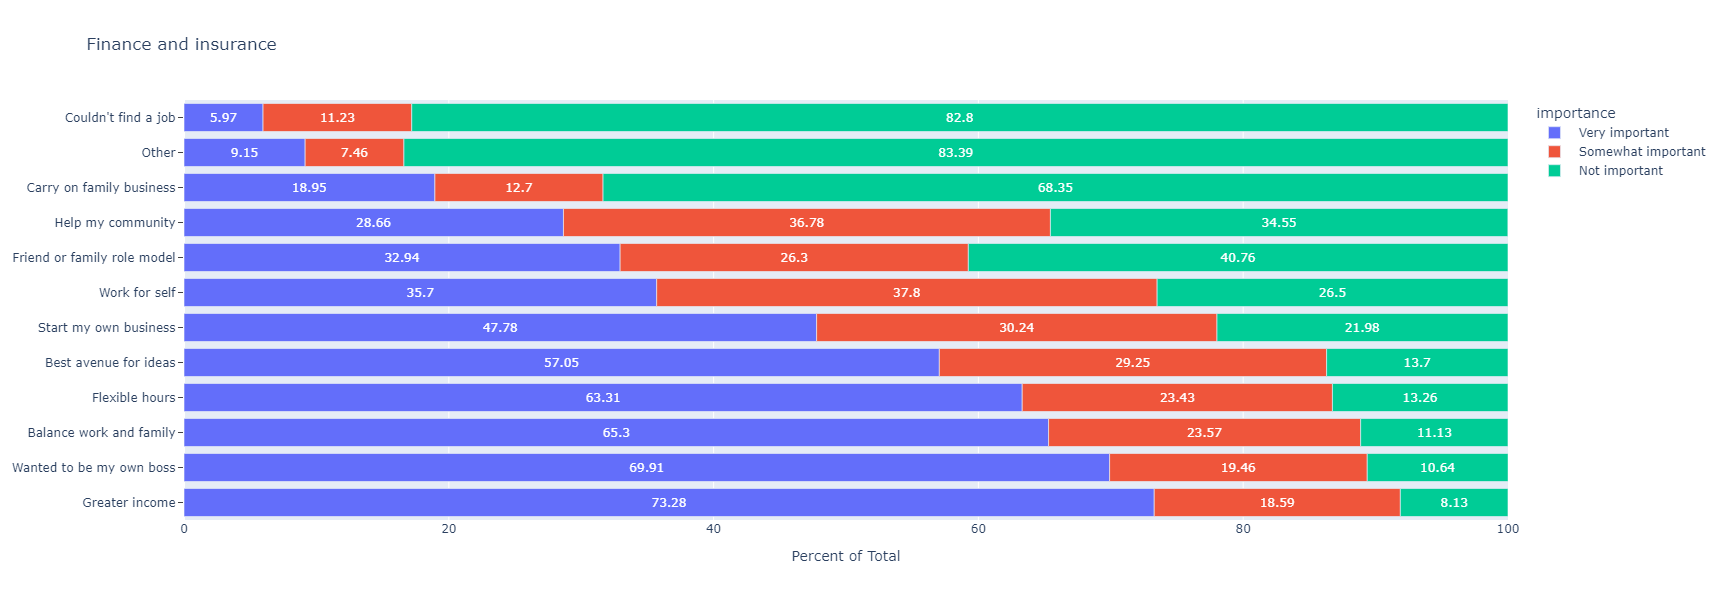

In [5]:
reason_owned = bus_own_df[
    (bus_own_df['qdesc_label'] == 'REASONOWN') &
    (~bus_own_df['industry'].str.contains('Total')) &
    (~bus_own_df['gender'].str.contains('All')) &
    (bus_own_df['ownchar_label'].str.contains(':'))]

reason_owned[['reason','importance']] = reason_owned.apply(
    lambda row: row['ownchar_label'].split(":"), axis = 1, result_type = 'expand'
)

reason_owned = reason_owned[['industry','gender','reason','importance','ownpdemp']]

grouped_reason = reason_owned.groupby(
    by = ['industry','reason','importance'])[['ownpdemp']].agg(
    responses = ('ownpdemp', 'sum')
)

grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

accom_subset = grouped_reason[(grouped_reason['industry'].str.contains('inanc'))]
accom_subset.sort_values(by = ['importance','ratio'], ascending = False, inplace = True)

picked_industry = accom_subset['industry'].unique().tolist()[0]

fig = px.bar(accom_subset, x = 'ratio', y = 'reason', color = 'importance',
            width = 1000, height = 600, orientation = 'h', title = picked_industry,
             hover_data = ['responses','ratio'], text = 'ratio'
            )
fig.update_layout(yaxis_title = None)

fig.update_traces(textposition = 'inside', insidetextanchor = 'middle', textfont = {'color': 'white'})
fig.update_yaxes(ticks = 'outside')
fig.update_layout(xaxis_title = "Percent of Total", uniformtext_minsize = 12,
                 uniformtext_mode = 'hide')

fig.update_xaxes(range = [0,100])

fig.show()